# Scalable Recommendation with Poisson Factorization
#### The following notebook is an example of the use of the implementation of the mean-field variational algorithm for approximate posterior inference for the Hierarchical Poisson Factorization, by Gopalan et al. (2013), followed by some visualizations.

The variational inference algorithm for HPF has been implemented and stored in the module **hpf_vi**.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special
import scipy.stats
import sklearn.metrics
from hpf_vi import hpf_vi
from sklearn.metrics import mean_squared_error

The dataset is a simulated sparse matrix of 0 and 1, which represents the interaction between users and items.

The simulated matrix contains clusters of similar users in terms of items consumed.

In [0]:
ratings = pd.read_pickle("ratings_df.pkl")
ratings = np.array(ratings)

Since we are in a parametric framework, the number of latent components is fixed. This hypothesis suggests that the model choice will not be automatic as in a non-parametric setup. Nevertheless, I ignore these difficulties for the moment, and fix $K$ to be equal to 10.

## Initialization of the variational parameters
The model implemented initialize the user parameters $\gamma_u$, and the item parameters $\lambda_i$ to the prior, plus a small random offset generated with a $\text{Uniform}(0,1)$.

In this way, $\gamma^{shp}_{uk} = a$ and $\gamma^{rte}_{uk} = a/b'$, so that the expectation of the variational $\theta$ is $b'$.\
Similarly, $\lambda_{ik}^{shp} = c$ and $\lambda_{ik}^{rte} = c/d'$, so that the expectation of the variational $\theta$ is $d'$.

Going up in the hierarchy, for the same reason, we set the variational parameters of $\xi_u$ and $\eta_i$, which are $k^{rte}_u$ and $\tau_i^{rte}$, to the prior, plus the same small random offset.

This initialization is embedded in the **hpf_vi** model.

In the following, a function that splits training and testing data is defined.

As suggested by the authors of the paper, the test set consists of randomly selected ratings, which are set to zero during the training.

In [0]:
def train_val_split(data, valid_dim=0.2):
        '''
        Creating two additional objects, i.e. training and validation set, which can be used in the fitting process

        Parameters:
        data = np.array
        valid_dim = float
        '''
        if valid_dim >= 1:
          raise ValueError("valid_dim must be lower than 1")

        train = data.copy()
        valid = np.zeros(data.shape)

        for u in np.unique(data.nonzero()[0]):
            ind = data[u].nonzero()[0] 

            if len(ind) > 0: 
                valid_ind = np.random.choice(ind, round(len(ind)*valid_dim), replace=False)
                for i in valid_ind:
                    valid[u,i], train[u,i] = data[u,i], 0
        return train, valid


In [0]:
train, valid = train_val_split(ratings)

We can now fit the model, using the predefined settings.

At the end of the training, in order to obtain the estimates for the entry of the observed matrix, we use the generative process of the model. In particular, we are going to generate the user preferences $\theta$ and the item attributes $\beta$, such that we can sample observation from a Poisson: $y_{ui} \sim Poisson(\beta_i\theta_u)$.

Note that in order to obtain the observation we need some Bayesian estimates of $\theta_u$ and $\beta_i$: hence, we  take the expectation of their variational distributions, which as always is the ratio between shape and scale.

In other words, recommendation is based on the prediction of each data point, called score, that mimics the generative process:
$$ score_{ui} = E[\theta_u\beta_i] $$
Thus, since we use variational estimate, we obtain:
$$ score_{ui} = E[\theta_u]E[\beta_i] $$

In the code, these values are stored in the object **predicted**.


In [10]:
model = hpf_vi() # instantiating the model
model.fit(train = train, valid = valid, iterations = 100)

Completed in 2801.084 seconds


In the following, a graph of the MSE for the validation and the training set is plotted as function of the number of iterations.

Ideally, the behavior of the MSE will help us understand if the model has converged.

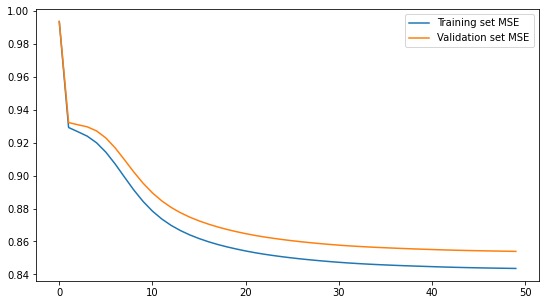

In [22]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(model.mse_train[:50],label="Training set MSE")
ax.plot(model.mse_valid[:50], label="Validation set MSE")
ax.legend();

Recommendations can now be made thanks to the estimated parameter. The method **recommend** suggests, for each user, the items that obtained the highest score.

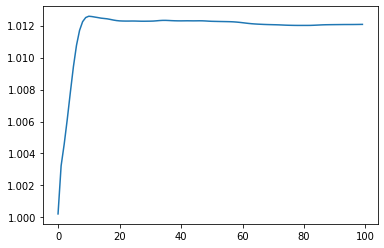

In [19]:
plt.plot(model.mse_valid/model.mse_train)

In [12]:
model.recommend(train)

User 0 may also like these items: [45, 66, 153, 181, 593, 992]
User 1 may also like these items: [59, 148, 184, 201, 221, 223, 418, 1081]
User 2 may also like these items: [45, 66, 153, 181, 593]
User 3 may also like these items: [59, 148, 184, 201, 221]
User 4 may also like these items: [61, 83, 282, 283, 286, 289, 294, 300, 322, 460]
User 5 may also like these items: [49, 61, 83, 251, 282, 283, 285, 286, 289, 292, 293, 294, 296, 300, 312, 319, 327, 338, 343, 455, 460, 492, 673, 695]
User 6 may also like these items: [49, 61, 83, 282, 283, 285, 286, 289, 294, 296, 300, 327, 338, 455, 460, 492, 673, 695]
User 8 may also like these items: [59, 148, 184, 201, 221, 223, 418, 1081]
User 9 may also like these items: [61, 83, 282, 283, 286, 289, 294, 300, 322, 343, 460, 695]
User 10 may also like these items: [203, 371, 480, 492, 534]
User 11 may also like these items: [49, 61, 83, 251, 282, 283, 285, 286, 289, 294, 296, 300, 327, 338, 343, 455, 460, 492, 673, 695]
User 13 may also like thes

## Plotting some results ##
In the following, we can qualitatively assess the in-sample performance of the model by comparing the actual vs predicted observations for 3 users of our dataset.

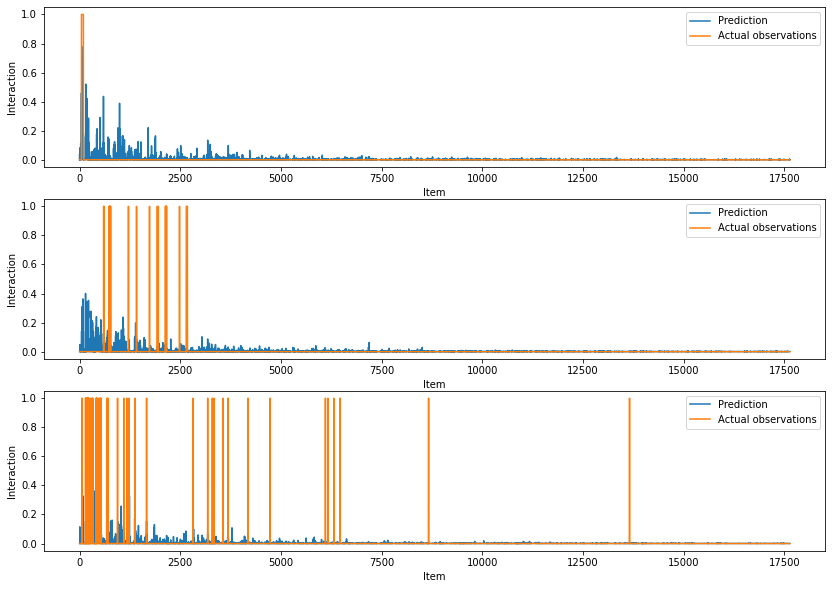

In [13]:
fig, axes = plt.subplots(figsize=(14, 10), nrows=3)
for u,i in enumerate([0,100,1800]):
    axes[u].plot(model.predicted[i]/model.predicted.max(), label = "Prediction")
    axes[u].plot(ratings[i], label = "Actual observations")
    axes[u].set_xlabel("Item")
    axes[u].set_ylabel("Interaction")
    axes[u].legend();

The following graph shows the performance on our test set.

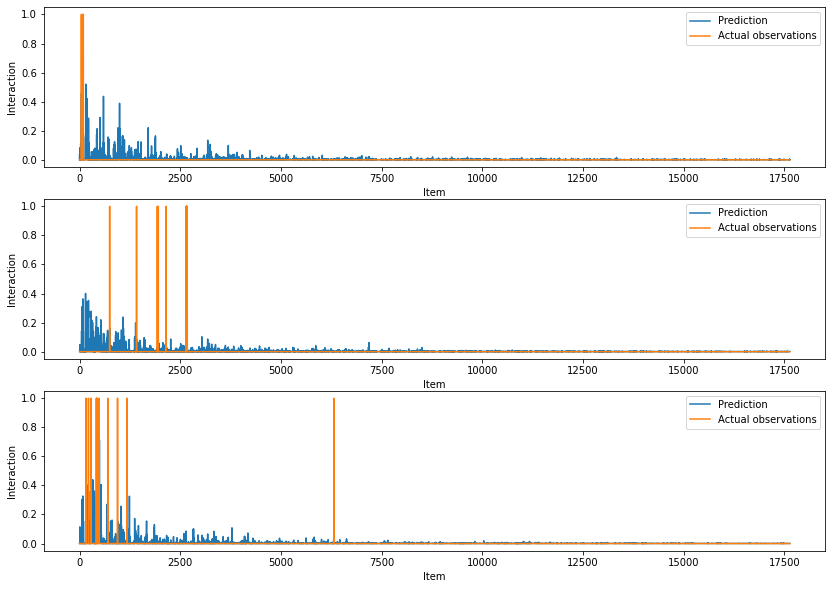

In [14]:
fig, axes = plt.subplots(figsize=(14, 10), nrows=3)
for u,i in enumerate([0,100,1800]):
    axes[u].plot(model.predicted[i]/model.predicted.max(), label = "Prediction")
    axes[u].plot(valid[i], label = "Actual observations")
    axes[u].set_xlabel("Item")
    axes[u].set_ylabel("Interaction")
    axes[u].legend();